# Analyzing Airbnb data of Toronto in 2019

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#'exec(%matplotlib inline)'
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor

In [119]:
data = pd.read_csv('AB_TO_2019.csv')

In [120]:
data.columns

Index(['id', 'name', 'host_name', 'host_is_superhost', 'host_listings_count',
       'neighbourhood', 'latitude', 'longitude', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price',
       'availability_365', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value'],
      dtype='object')

## Cleaning Data

In [121]:

#fill NaNs with 0
data.fillna({'bathrooms':0,'bedrooms':0,'beds':0,'host_listings_count':0}, inplace = True)

#drop undesired predictive columns
data.drop(['id', 'name','host_name','review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_communication','review_scores_location','review_scores_value','review_scores_checkin'], axis=1, inplace=True)

#remove outliers
data = data.loc[data['price']<=700]

#only use top 10 neighbourhoods
top_10_nb = data.neighbourhood.value_counts().head(10).index.tolist()
df_1 = data.loc[data['neighbourhood'].isin(top_10_nb)]

#only use top 5 property types
top_5_property_types = df_1.property_type.value_counts().head(5).index.tolist()
df_2 = df_1.loc[df_1['property_type'].isin(top_5_property_types)]


In [122]:
#process categorical features into numerical
df_2['neighbourhood'] = df_2['neighbourhood'].astype('category').cat.codes
df_2['room_type'] = df_2['room_type'].astype('category').cat.codes
df_2['property_type']= df_2['property_type'].astype('category').cat.codes
df_2['host_is_superhost']= df_2['host_is_superhost'].astype('category').cat.codes

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [123]:
df_2.describe()

,host_is_superhost,host_listings_count,neighbourhood,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,availability_365
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,0.291529,5.791379,2.305431,43.658102,-79.395336,1.006501,0.257026,3.275628,1.236874,1.288429,1.672167,155.050705,107.776078
std,0.455149,13.543588,3.015119,0.030030,0.021401,1.004520,0.461288,1.909494,0.503808,0.771062,1.002665,103.119588,121.621160
min,-1.000000,0.000000,0.000000,43.632820,-79.459700,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,0.000000,1.000000,0.000000,43.642185,-79.408530,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,89.000000,0.000000
50%,0.000000,1.000000,1.000000,43.648800,-79.394910,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,129.000000,61.000000
75%,1.000000,4.000000,4.000000,43.662470,-79.382280,1.000000,0.000000,4.000000,1.000000,2.000000,2.000000,196.000000,176.500000
max,1.000000,134.000000,9.000000,43.783810,-79.325690,4.000000,2.000000,16.000000,11.500000,8.000000,14.000000,700.000000,365.000000


## Preparing Data for Train/Test

In [124]:

X = df_2[['host_is_superhost', 'host_listings_count', 'neighbourhood', 'latitude',
         'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds','availability_365']]


In [125]:
y= df_2[['price']]

In [126]:
#separate it into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [127]:
df_2.isnull().sum()

host_is_superhost      0
host_listings_count    0
neighbourhood          0
latitude               0
longitude              0
property_type          0
room_type              0
accommodates           0
bathrooms              0
bedrooms               0
beds                   0
bed_type               0
price                  0
availability_365       0
dtype: int64

In [128]:
#fit and transform xtrain data using minmax scaler.
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

## Fit and Predit MLR Model

In [129]:
#create the model and fit (Train it) x_train (after scaling) and y_train (no scaling)
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [130]:
#transform x_test
X_test_scaled = scaler.transform(X_test)

In [131]:
#predict using xtest transformed
y_pred = model.predict(X_test_scaled)

In [132]:
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)

In [133]:
error_frame = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': y_pred.flatten()})

In [109]:
error_frame.head()

,Actual,Predicted
0,157,185.688340
1,125,131.472575
2,199,163.740029
3,150,458.262567
4,51,34.356455


In [141]:
# The coefficients (m, b) of y = mx + b
print('Coefficients ): \n', model.coef_)
print('Intercept (b): \n', model.intercept_)

print("Mean residual sum of squares = %.2f"
      % rmse)
print('R2 = %.2f' % r2)

print('%.2f of the variations can me explained by the models input' %r2)

Coefficients ): 
 [[  -8.01734823  117.29161095  -17.85836956  -44.34897581   21.69029408
    22.08729059 -115.81957868  157.7556184   321.20124965  230.04802572
    -9.93726117   35.24149598]]
Intercept (b): 
 [61.78384545]
Mean residual sum of squares = 74.65
R2 = 0.43
0.43 of the variations can me explained by the models input


Text(0.5,1,'Actual vs Predicted Values for Price per Night')

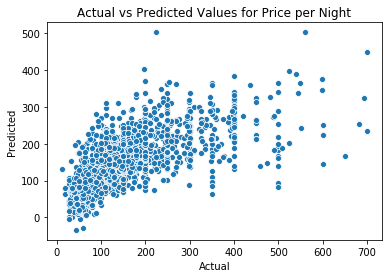

In [137]:
viz_1 = sns.scatterplot(x="Actual", y="Predicted", data=error_frame)
viz_1.set_title('Actual vs Predicted Values for Price per Night')

In [138]:
# to see how the residual errors behave
residual_error = error_frame.Actual - error_frame.Predicted
print("Mean of residuals =", np.mean(residual_error))
print("Standard deviation of residuals =", np.std(residual_error))

Mean of residuals = -1.9774071249879575
Standard deviation of residuals = 74.62265045037981


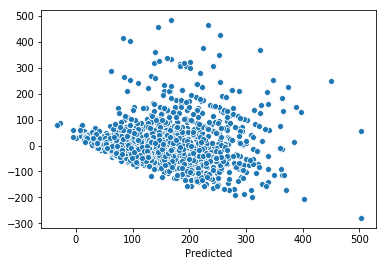

In [145]:


viz_2 = sns.scatterplot(error_frame.Predicted ,residual_error)

Text(0.5,1,'Residual Plot')

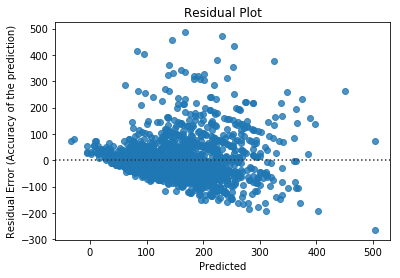

In [152]:
viz_3 = sns.residplot(x=error_frame.Predicted ,y=residual_error, data=error_frame)
viz_3.set_ylabel('Residual Error (Accuracy of the prediction)')
viz_3.set_title('Residual Plot')

Each point represents the price of an Airbnb listing. The distance of each point from 0 represents the quality of the prediction. If the point are close to 0, then the model did a good job. If the model is far from 0, then the model did a bad job. 

Now if the point lies on the positive side of the y-axis, this means that the prediction was lower than the actual value. Otherwise, the predcition was too high. If the point lies at 0, then the model perfectly predicted the price.


Text(0.5,1,'Distribution of Residual Error')

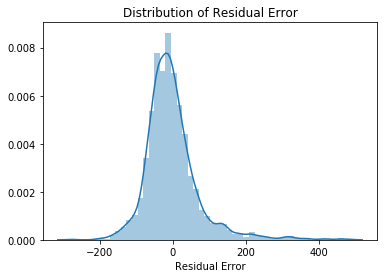

In [158]:
viz_4 = sns.distplot(residual_error)
viz_4.set_xlabel('Residual Error')
viz_4.set_title('Distribution of Residual Error')